---
title: "Auto Clipper Redux"
author: "Ali Zaidi"
date: "2025-11-26"
categories: [Data Engineering, Automated Annotation]
description: "Now that we have new data coming in lets clip every swing and find our labels"
format:
  html:
    code-fold: true
jupyter: python3
---

In [1]:
#| include: false 
from fastai.vision.all import *
from eagle_swing.clipper import *

In [2]:
# #| include: false 
# pkl_files = get_files('../../../data/full_videos/saugusta/', extensions='.pkl')
# len(pkl_files)

In [3]:
# video_names = [file.name.split('.')[0] for file in pkl_files]
# fname2path = dict(zip(video_names, pkl_files))
# print(video_names)

In [4]:
# stef_scores = {}
# stef_scores[video_names[0]] = [3, 5, 4, 3, 4]
# stef_scores[video_names[1]] = [1, 3, 4, 5, 3]
# stef_scores[video_names[2]] = [4, 4, 2, 4, 1, 3]
# stef_scores[video_names[3]] = [4, 5, 3, 5]
# stef_scores[video_names[4]] = [5, 2, 5, 3, 4, 4]
# stef_scores[video_names[5]] = [5, 5, 3, 4, 1]
# stef_scores[video_names[6]] = [1, 4, 3, 5]

In [5]:
# import itertools

# clip_holder = []
# scores_series = pd.Series(stef_scores.values()).map(lambda x: [f'swing_{idx}_score_{score}' for idx, score in enumerate(x)])
# init_df = pd.DataFrame([video_names, scores_series], index=['video_name','swing_info']).T
# for _, row in init_df.iterrows():
#     vname = row['video_name']
#     for item in row['swing_info']:
#         clip_holder.append(f'{vname}_{item}')


# final_df = pd.DataFrame(clip_holder, columns=['clip_name'])
# final_df['video_name'] = final_df.clip_name.map(lambda x: '_'.join(x.split('_')[:2]))
# final_df['swing_idx'] = final_df.clip_name.map(lambda x: x.split('_')[3])
# final_df['score'] = final_df.clip_name.map(lambda x: x.split('_')[-1])
# highest_wrists_list = [get_highest_wrist_only(file) for file in pkl_files]
# flat_wrist_list = list(itertools.chain.from_iterable(highest_wrists_list))
# final_df['pkl_path'] = final_df.video_name.map(lambda x: fname2path[x])
# final_df['first_highest_wrist_idx'] = flat_wrist_list
# final_df.head(2)
###
### df.to_csv('stef_lbls.csv', index=False) ##
###

In [6]:
df = pd.read_csv('stef_lbls.csv').reset_index(drop=True)
df.head(2)

,clip_name,video_name,swing_idx,score,pkl_path,first_highest_wrist_idx
0,IMG_1174_swing_0_score_3,IMG_1174,0,3,../../../data/full_videos/saugusta/IMG_1174/keypoints/IMG_1174.pkl,996
1,IMG_1174_swing_1_score_5,IMG_1174,1,5,../../../data/full_videos/saugusta/IMG_1174/keypoints/IMG_1174.pkl,2333


In [7]:
df5 = df[df.score == 5].reset_index(drop=True)
df1 = df[df.score == 1].reset_index(drop=True)
df_low_high = pd.concat([df1, df5], ignore_index=True)
len(df5), len(df1)

(9, 4)

In [8]:
before_increment = 90
after_increment = 60
df_low_high['start_idx'] = df_low_high.first_highest_wrist_idx - before_increment
df_low_high['end_idx'] = df_low_high.first_highest_wrist_idx + after_increment

In [9]:
kp_holder = []
for x in range(len(df_low_high)):
    row = df_low_high.iloc[x]
    pkl_file = row.pkl_path
    start_idx = row.start_idx
    end_idx = row.end_idx
    kp_holder.append(KpExtractor(pkl_file,
                                post_processors=[                             
                                    #normalize_by_average_torso,
                                     #center_by_average_torso,
                                     rescale_for_visualization]
                                ).kps[start_idx: end_idx])
df_low_high['kps'] = kp_holder

In [10]:
from eagle_swing.lower_body import *
from eagle_swing.upper_body import *

In [11]:
plt.style.use('dark_background')

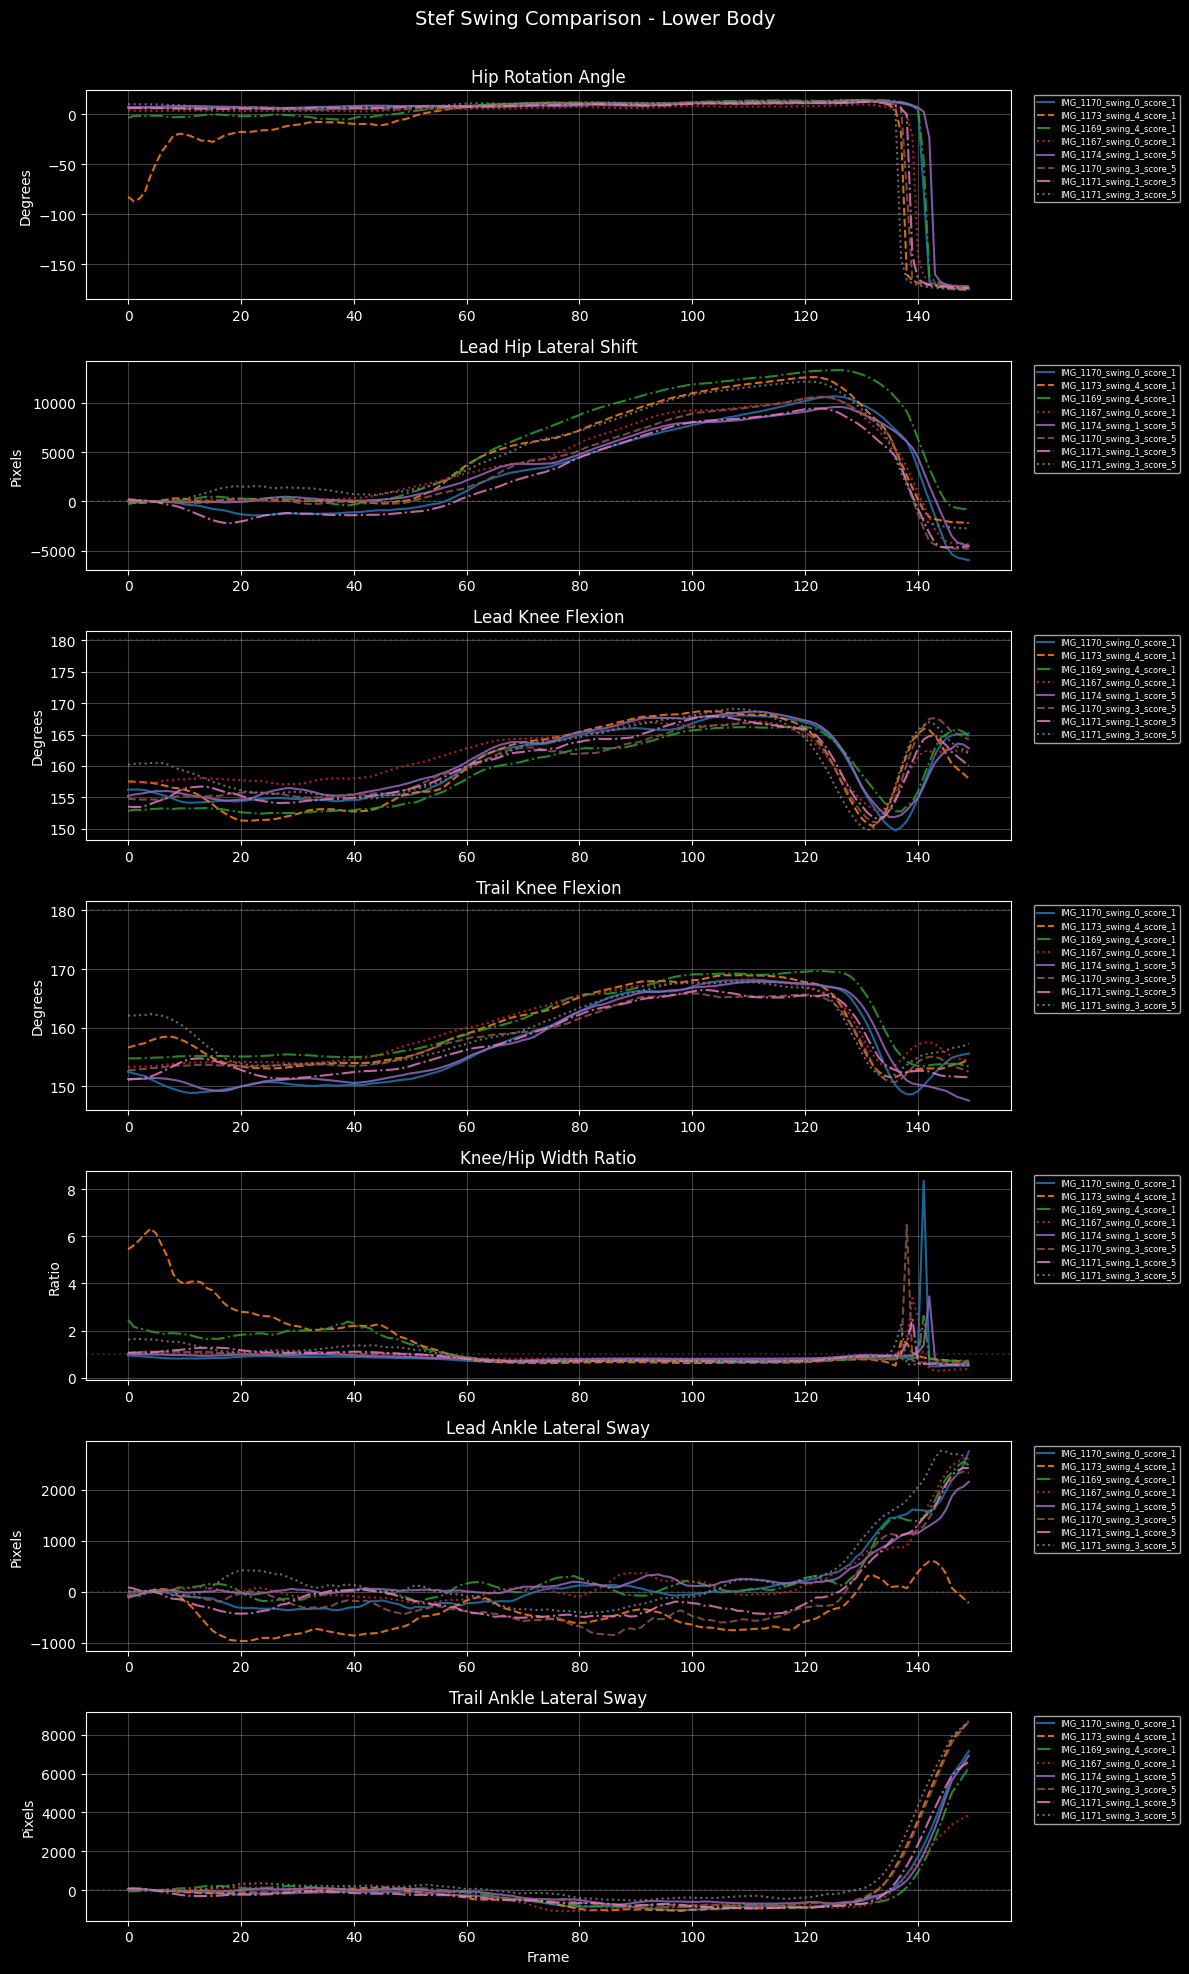

In [12]:
fig, axes = plot_lower_body_detailed(
    kps_list=df_low_high.kps.values[:8],
    #scores_list=df_low_high.kps.values[...,:2],
    labels=df_low_high.clip_name[:8],
    params=PlotParams(handedness="right", smooth_win=3, fps=60.0),
    title="Stef Swing Comparison - Lower Body"
);

In [13]:
upper_kps = [x[...,:2] for x in df_low_high.kps.values[:8]]

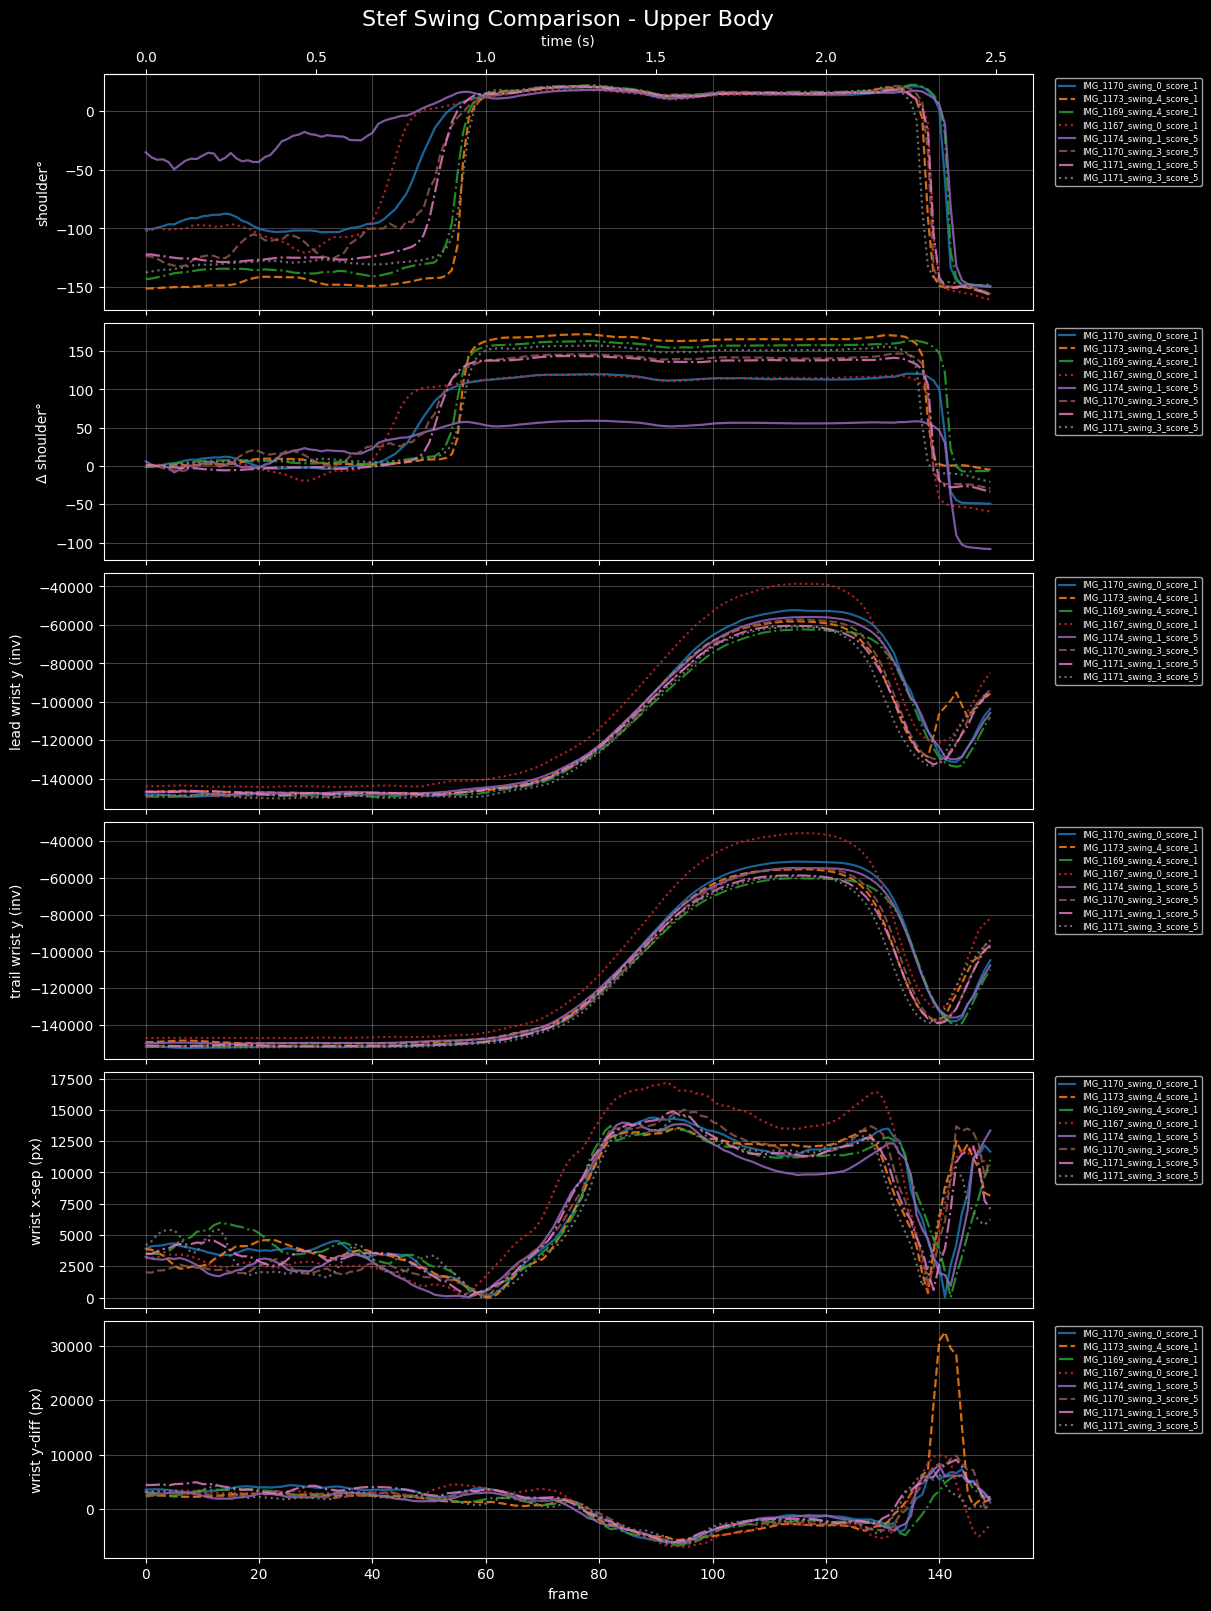

In [14]:
fig, axes = plot_upper_body_comparison(
    #kps_list=df_low_high.kps.values[:8],
    kps_list=upper_kps,
    #scores_list=df_low_high.kps.values[...,:2],
    labels=df_low_high.clip_name[:8],
    params=UpperPlotParams(handedness="right", smooth_win=5, fps=60.0),
    title="Stef Swing Comparison - Upper Body"
)

In [12]:
# swing_kps0, swing_frames0, swing_idxs0 = get_clips(pkl_files[6], 
#                                                   resize_dim=None)
# view_videos_grid(swing_frames0)